In [5]:
import imutils
from imutils import contours
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 신용카드 종류
FIRST_NUMBER={
    "3":"American Express",
    "4":"Visa",
    "5":"MasterCard",
    "6":"Discover Card"
}

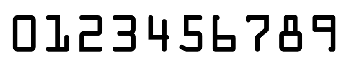

In [38]:
# OCR-A 이미지 로드
ref = cv2.imread("ocr_a_reference.png")
plt.figure()
plt.axis("off")
plt.imshow(ref)



Grayscale Image / Pixel당 8bit, 즉 256단계의 명암을 표현할 수 있는 이미지 <br>
Color Image / Pixel당 24bit / OpenCV에서는 BGR로 표현


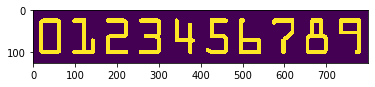

In [39]:

# convert image
ref=cv2.cvtColor(ref,cv2.COLOR_BGR2GRAY)
# threshold는 임계값 이상이면 어떤 값으로 바꿔주고 낮으면 0으로 바꿔주는 기능
# 10보다 크면 0 아니면 value
# black 0 / white 255
ref=cv2.threshold(ref,10,255,cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

### 이미지 컨투어
컨투어란 동일한 색 또는 동일한 픽셀값을 가지고 있는 영역의 경계선 정보다. 물체의 윤곽선,외형을 파악하는데 사용된다. <br>
OpenEV의 findContours 함수로 이미지의 컨투어 정보, 컨투어의 상하구조 정보를 출력한다. 흑백이미지 또는 이진화된 이미지만 적용할 수 있다. <br>


In [50]:
# cv2.RETR_EXTERNAL / 컨투어 라인 중 가장 바깥쪽의 라인만 찾음
# CHAIN_APPROX_SIMPLE / 컨투어 라인을 그릴 수 있는 포인트만 반환
refCnts=cv2.findContours(ref.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts=refCnts[1] if imutils.is_cv3() else refCnts[0]
# 왼쪽부터 오른쪽으로 좌표를 정렬
refCnts=contours.sort_contours(refCnts,method='left-to-right')[0]

In [51]:
refCnts

(array([[[ 24,  20]],
 
        [[ 23,  21]],
 
        [[ 20,  21]],
 
        [[ 16,  25]],
 
        [[ 16,  26]],
 
        [[ 15,  27]],
 
        [[ 15,  98]],
 
        [[ 16,  99]],
 
        [[ 16, 100]],
 
        [[ 19, 103]],
 
        [[ 21, 103]],
 
        [[ 22, 104]],
 
        [[ 60, 104]],
 
        [[ 61, 103]],
 
        [[ 62, 103]],
 
        [[ 63, 102]],
 
        [[ 64, 102]],
 
        [[ 65, 101]],
 
        [[ 65, 100]],
 
        [[ 66,  99]],
 
        [[ 66,  98]],
 
        [[ 67,  97]],
 
        [[ 67,  28]],
 
        [[ 66,  27]],
 
        [[ 66,  25]],
 
        [[ 63,  22]],
 
        [[ 62,  22]],
 
        [[ 61,  21]],
 
        [[ 59,  21]],
 
        [[ 58,  20]]], dtype=int32), array([[[ 98,  20]],
 
        [[ 97,  21]],
 
        [[ 96,  21]],
 
        [[ 94,  23]],
 
        [[ 94,  27]],
 
        [[ 96,  29]],
 
        [[114,  29]],
 
        [[116,  31]],
 
        [[116,  94]],
 
        [[115,  95]],
 
        [[ 97,  95]],
 
    

In [45]:
digits = {}

In [62]:
ref

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [54]:
for (i,c) in enumerate(refCnts):
    # contours로 부터 bouding box 추출
    (x,y,w,h)=cv2.boundingRect(c)
    # 원본 해당 영역의 숫자 정보 추출
    roi=ref[y:(y+h) , x:(x+w)]
    roi2=cv2.resize(roi, (57,88))
    digits[i]=roi

In [58]:
digits[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [59]:
digits[1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8)

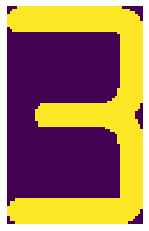

In [63]:
plt.figure()
plt.axis("off")
plt.imshow(digits[3])

### 이미지 변환 방법
- Erosion : and연산 / 글자가 사라질 수 있음
- Dilation : or연산 / 글자가 굵어질 수 있음

- Opening : erosion을 수행한 후 dilation을 바로 적용해준다 -> 작은 noisy를 없애는 데 사용한다.
- Closing : dilation을 수행한 후 erosion을 바로 적용 -> 전반적인 이미지가 깨끗해진다. <br>
참고 )https://hoony-gunputer.tistory.com/entry/opencv-pythonErosion%EA%B3%BC-Dilation


In [65]:
# 이미지 전처리 
# MORPH_RECT 만들 모형 / 인자사이즈
rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(9,3))
sqKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

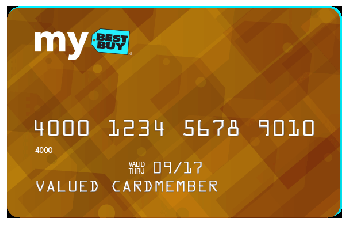

In [67]:
# load test image
image=cv2.imread('credit_card_01.png')
plt.figure()
plt.axis('off')
plt.imshow(image)

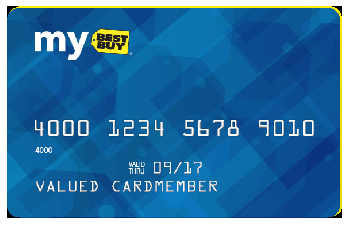

In [68]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.figure()
plt.axis("off")
plt.imshow(image)

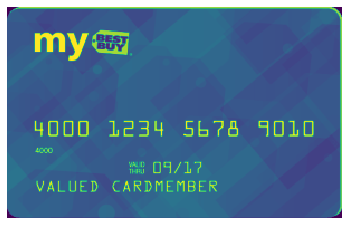

In [69]:
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray)

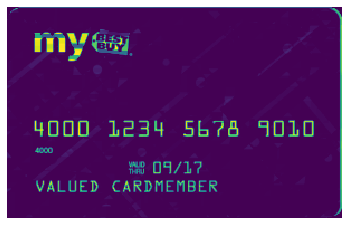

In [70]:
# MORPH_TOPHAT / 원본이미지와 opening 결과와의차이
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.figure()
plt.axis("off")
plt.imshow(tophat)

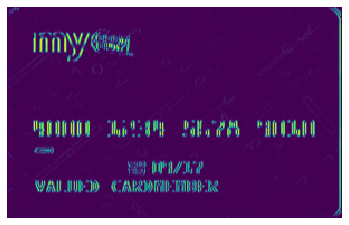

In [72]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
plt.figure()
plt.axis("off")
plt.imshow(gradX)

In [73]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

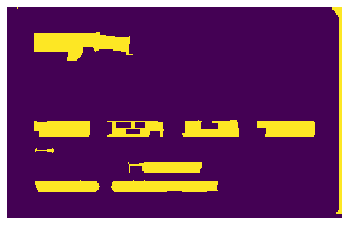

In [74]:
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [75]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv3() else cnts[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [77]:
locs = []

In [78]:
# loop over the contours
for (i, c) in enumerate(cnts):
    # compute the bounding box of the contour, then use the
    # bounding box coordinates to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
 
    # since credit cards used a fixed size fonts with 4 groups
    # of 4 digits, we can prune potential contours based on the
    # aspect ratio
    if ar > 2.5 and ar < 4.5:
        # contours can further be pruned on minimum/maximum width
        # and height
        if (w > 40 and w < 70) and (h > 10 and h < 20):
            # append the bounding box region of the digits group
            # to our locations list
            locs.append((x, y, w, h))

In [79]:
# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])

In [80]:
locs

[(24, 102, 50, 14), (90, 102, 51, 14), (157, 101, 51, 15), (224, 102, 52, 14)]

In [81]:
output = []

In [82]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []
 
    # extract the group ROI of 4 digits from the grayscale image,
    # then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    # detect the contours of each individual digit in the group,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    
    digitCnts = digitCnts[1] if imutils.is_cv3() else digitCnts[0]
    # digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    digitCnts = contours.sort_contours(digitCnts,
    method="left-to-right")[0]

    # loop over the digit contours
    for c in digitCnts:
        # compute the bounding box of the individual digit, extract
        # the digit, and resize it to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
 
        # initialize a list of template matching scores	
        scores = []
 
        # loop over the reference digit name and digit ROI
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI,
                                       cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
 
        # the classification for the digit ROI will be the reference
        # digit name with the *largest* template matching score
        groupOutput.append(str(np.argmax(scores)))
        # draw the digit classifications around the group
        cv2.rectangle(image, (gX - 5, gY - 5),
                      (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
 
    # update the output digits list
    output.extend(groupOutput)

In [83]:

# display the output credit card information to the screen
print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))

Credit Card Type: Visa


In [84]:
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 4000123456789010


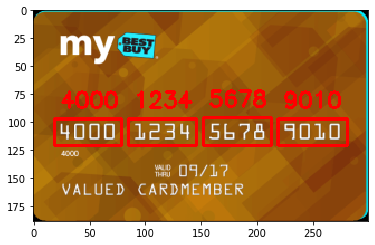

In [85]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))